# 03 - Williams Significance Test

Compare metric correlations using Williams test for dependent correlations.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_all_datasets, get_metric_names
from src.statistics import williams_test, compute_significance_analysis
from src.visualization import plot_williams_heatmap, plot_combined_heatmaps

plt.style.use('seaborn-v0_8-whitegrid')

results_dir = project_root / 'results'
figures_dir = results_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

ALPHA = 0.05
print('Setup complete!')

Setup complete!


## 1. Williams Test Example

In [2]:
# Example
r12 = 0.75  # Metric A with human
r13 = 0.65  # Metric B with human
r23 = 0.80  # Metric A with Metric B
n = 100

t_stat, p_value = williams_test(r12, r13, r23, n)

print('Williams Test Example:')
print(f'  Metric A corr: {r12:.2f}')
print(f'  Metric B corr: {r13:.2f}')
print(f'  t-statistic: {t_stat:.3f}')
print(f'  p-value: {p_value:.4f}')
print(f'  Significant at alpha=0.05: {p_value < 0.05}')

Williams Test Example:
  Metric A corr: 0.75
  Metric B corr: 0.65
  t-statistic: 2.359
  p-value: 0.0102
  Significant at alpha=0.05: True


## 2. Load Datasets

In [3]:
datasets = load_all_datasets()

Loading all datasets...

ARTS:
  ARTS94: 94 samples, 10 metrics
  ARTS300: 300 samples, 10 metrics
  ARTS3k: 2999 samples, 8 metrics

SDA:
  SDA: 600 samples, 30 metrics

Human-annotated:
  ST-sent: 1620 samples, 29 metrics, scale (1, 7)
  ST-para: 271 samples, 29 metrics, scale (1, 7)
  D-Wiki: 601 samples, 29 metrics, scale (1, 5)


## 3. Compute Significance Analysis

In [4]:
significance_results = {}

for dataset_name, data in datasets.items():
    print(f'\nAnalyzing {dataset_name}...')
    
    human = data['human_scores']
    metrics = data['metric_scores']
    
    # Prepare metric scores dict (exclude 'human')
    metric_scores = {k: v for k, v in metrics.items() if k != 'human'}
    
    # Handle NaN
    valid_mask = ~np.isnan(human)
    human_clean = human[valid_mask]
    metric_scores_clean = {k: v[valid_mask] for k, v in metric_scores.items()}
    
    # Compute significance analysis
    result = compute_significance_analysis(
        metric_scores_clean,
        human_clean,
        method='pearson',
        alpha=ALPHA,
    )
    
    significance_results[dataset_name] = result
    
    print(f'  Sample size: {len(human_clean)}')
    print(f'  Top metrics: {result["top_metrics"][:5]}')


Analyzing ARTS94...
  Sample size: 94
  Top metrics: ['Ours_RF', 'BATS-GB']

Analyzing ARTS300...
  Sample size: 300
  Top metrics: ['Claude(simp)']

Analyzing ARTS3k...
  Sample size: 2999
  Top metrics: ['Claude(simp)']

Analyzing SDA...
  Sample size: 600
  Top metrics: ['Claude(simp+src+ref)']

Analyzing ST-sent...
  Sample size: 1620
  Top metrics: ['BATS-RF', 'Ours_RF', 'BATS-GB']

Analyzing ST-para...
  Sample size: 271
  Top metrics: ['SARI', 'Claude(simp)', 'BLEU']

Analyzing D-Wiki...
  Sample size: 601
  Top metrics: ['BATS-RF', 'Claude(simp+src)']


## 4. Correlation Rankings

In [5]:
for dataset_name in ['ARTS3k', 'SDA', 'ASSET']:
    if dataset_name in significance_results:
        result = significance_results[dataset_name]
        print(f'\n{dataset_name} - Correlations:')
        print('=' * 50)
        display(result['correlations_df'].head(10))


ARTS3k - Correlations:


,metric,correlation,p_value,n,ci_lower,ci_upper,ci_width
0,Claude(simp),-0.688252,0.000000e+00,2999.0,-0.706637,-0.668938,0.037699
1,Ours_RF,0.620514,9.115709e-319,2999.0,0.598003,0.642047,0.044044
2,SLE,-0.613465,1.275346e-309,2999.0,-0.635308,-0.590642,0.044666
3,Word_Count,0.530282,3.684350e-217,2999.0,0.504057,0.555531,0.051474
4,FKGL,0.491612,2.684393e-182,2999.0,0.463983,0.518284,0.054301
5,Avg_Word_Len,0.148867,2.511900e-16,2999.0,0.113680,0.183681,0.070001
6,Random,-0.026838,1.417230e-01,2999.0,-0.062571,0.008963,0.071533
7,Shuffle,-0.006277,7.311502e-01,2999.0,-0.042060,0.029522,0.071582



SDA - Correlations:


,metric,correlation,p_value,n,ci_lower,ci_upper,ci_width
0,Claude(simp+src+ref),0.725430,4.382938e-99,600.0,0.685171,0.761270,0.076099
1,Claude(simp+src),0.676291,1.991288e-81,600.0,0.630371,0.717495,0.087124
2,Claude(simp+ref),0.638985,3.672514e-70,600.0,0.589069,0.684042,0.094973
3,LENS-SALSA,0.573003,1.183014e-53,600.0,0.516655,0.624408,0.107753
4,BERTScore_P,0.567153,2.293839e-52,600.0,0.510273,0.619092,0.108819
5,bertscore_f1,0.475661,3.347762e-35,600.0,0.411275,0.535323,0.124048
6,bertscore_r,0.365089,2.348213e-20,600.0,0.293625,0.432494,0.138869
7,Claude(simp),0.363214,3.778720e-20,600.0,0.291648,0.430735,0.139087
8,rouge2,0.334307,3.926882e-17,600.0,0.261254,0.403553,0.142299
9,SARI(ASSET),0.330599,9.093497e-17,600.0,0.257365,0.400057,0.142692


## 5. Significance Matrices

In [6]:
# Show significance matrix for ARTS3k
dataset_name = 'ARTS3k'
result = significance_results[dataset_name]

print(f'Significance Matrix - {dataset_name}')
print('(1 = row significantly better, -1 = row significantly worse, 0 = no difference)')
display(result['significance_matrix'])

Significance Matrix - ARTS3k
(1 = row significantly better, -1 = row significantly worse, 0 = no difference)


,Claude(simp),Ours_RF,SLE,Word_Count,FKGL,Avg_Word_Len,Random,Shuffle
Claude(simp),False,True,True,True,True,True,True,True
Ours_RF,False,False,False,True,True,True,True,True
SLE,False,False,False,True,True,True,True,True
Word_Count,False,False,False,False,True,True,True,True
FKGL,False,False,False,False,False,True,True,True
Avg_Word_Len,False,False,False,False,False,False,True,True
Random,False,False,False,False,False,False,False,False
Shuffle,False,False,False,False,False,False,False,False


Saved: /home/benjamin/work/github_repositories/Evaluating-Text-Simplicity-Is-Not-That-Simple/results/figures/williams_all_datasets.png


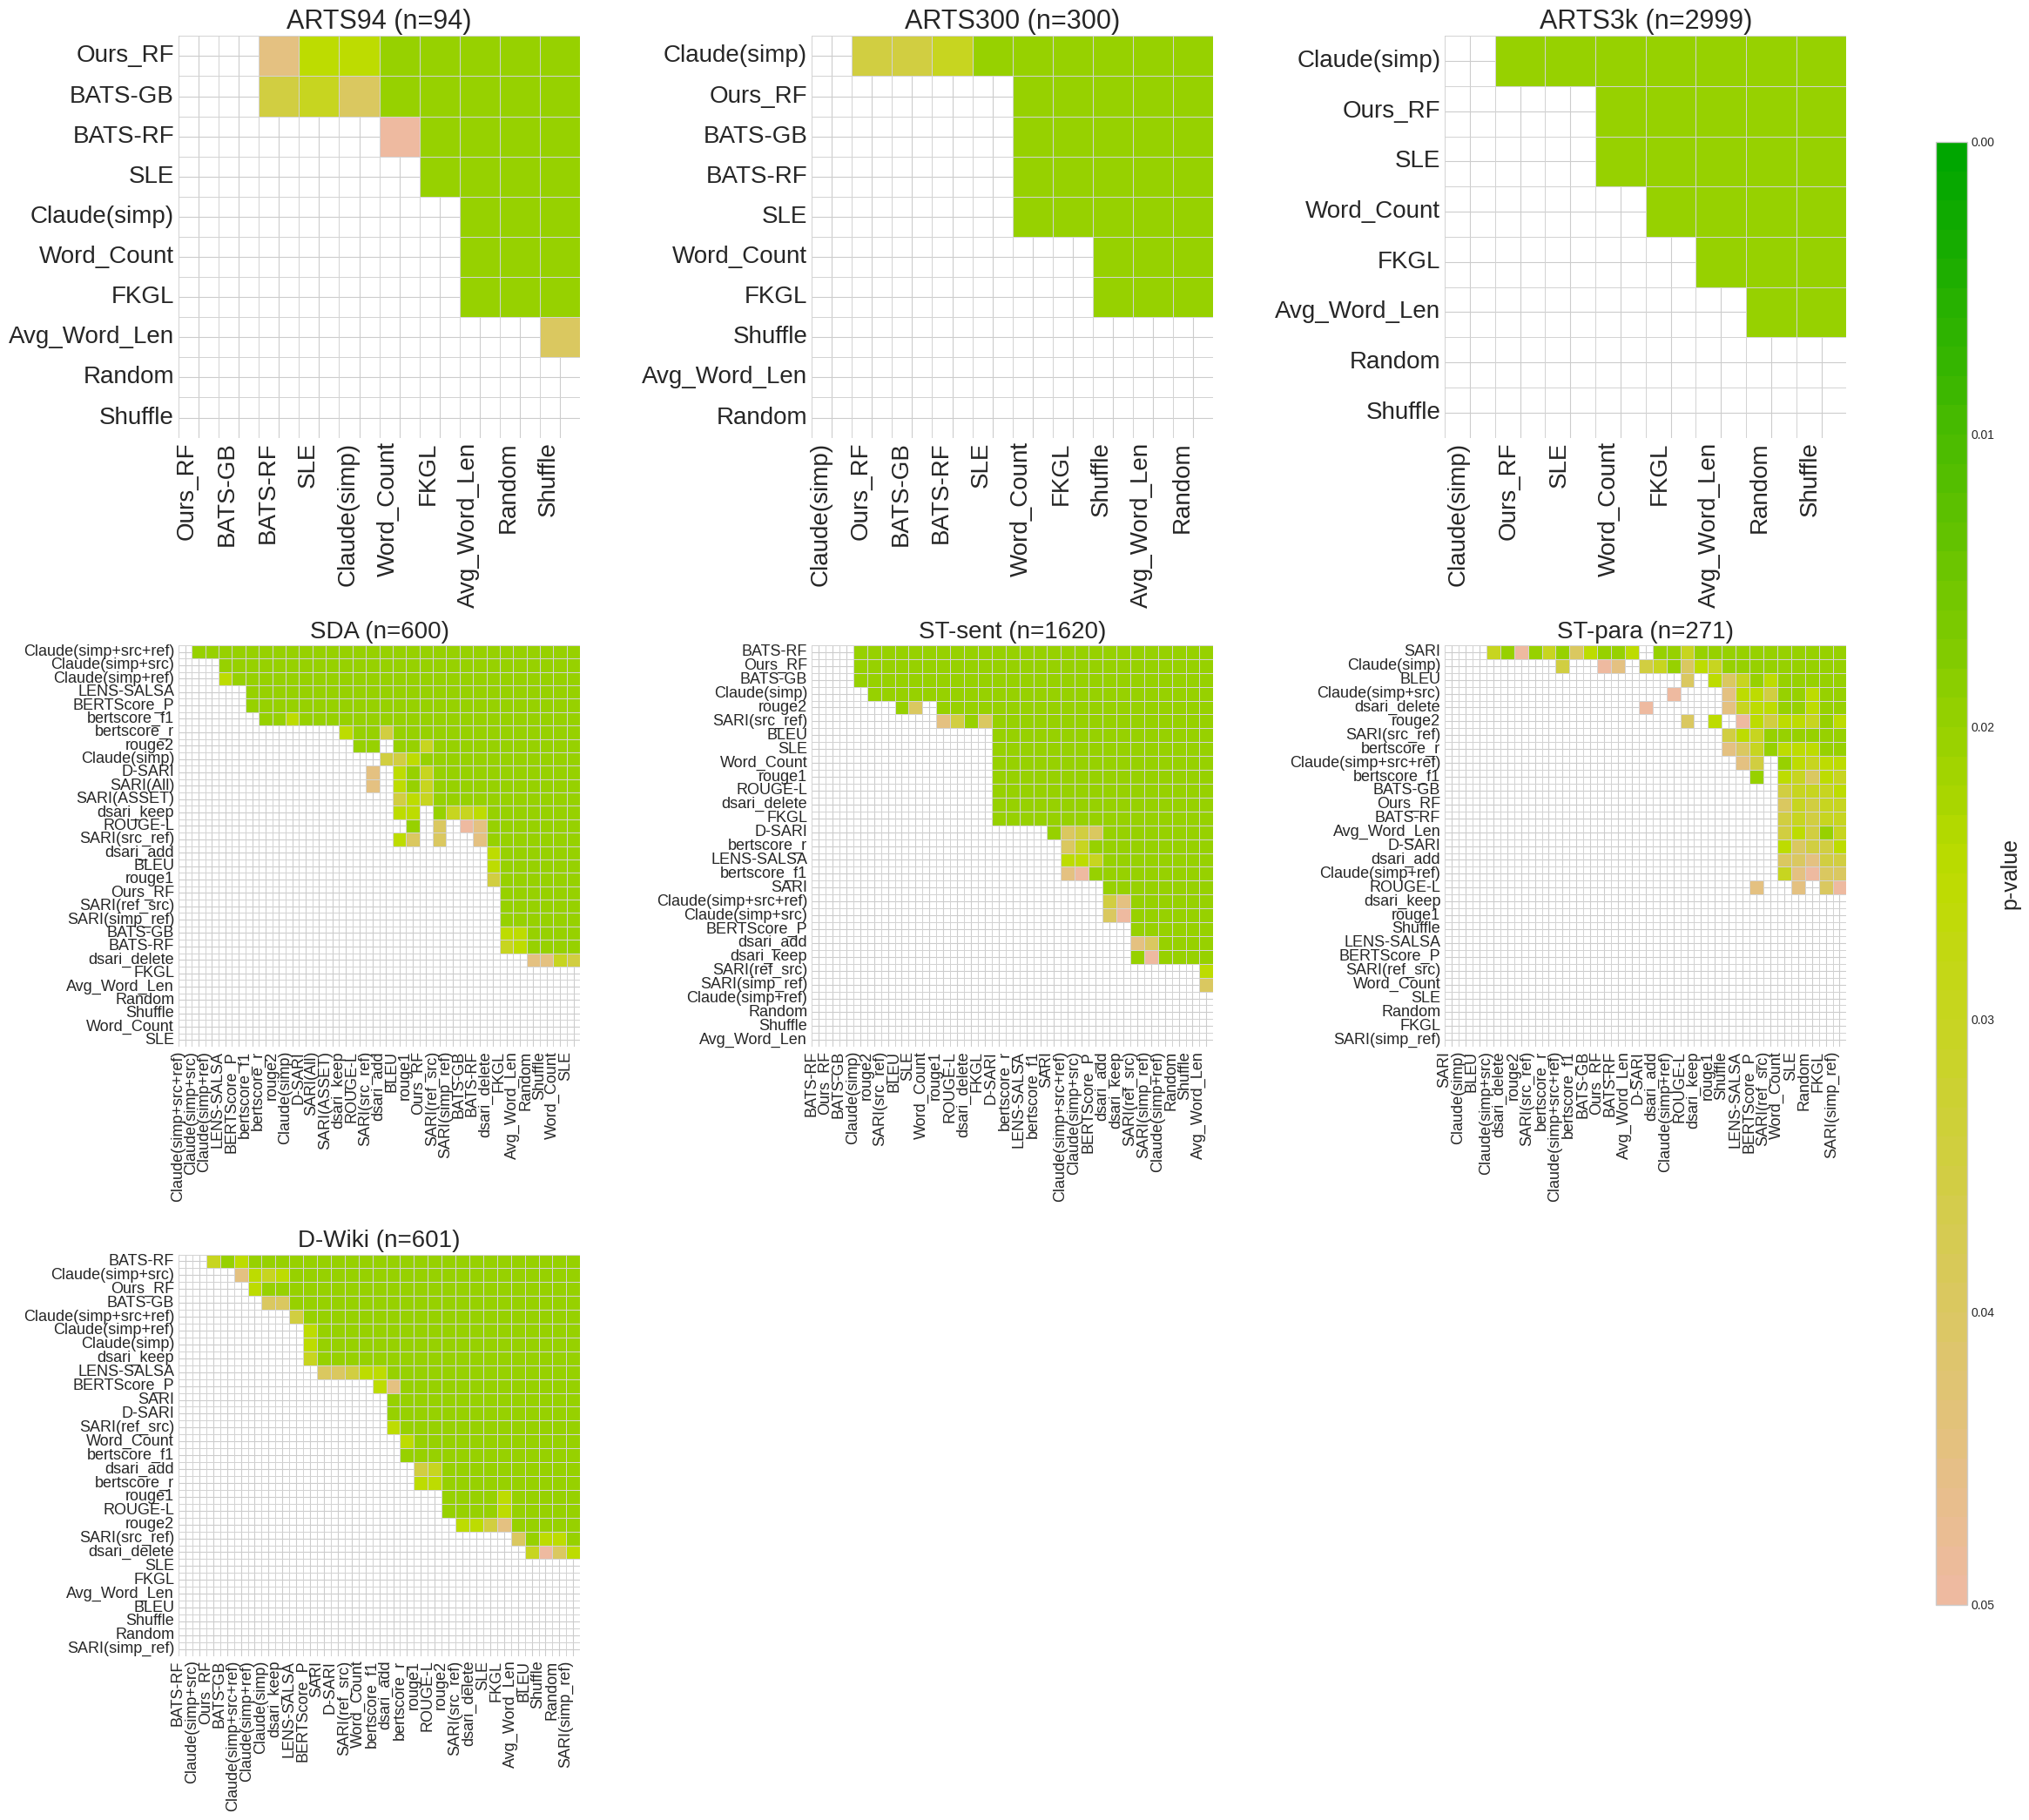

In [7]:
# Plot combined Williams heatmaps for all datasets
fig = plot_combined_heatmaps(
    significance_results,
    n_cols=3,
    figsize_per_plot=(8, 7),
    alpha=ALPHA,
    sort_by_wins=True,
    save_path=figures_dir / 'williams_all_datasets.png',
)
plt.show()

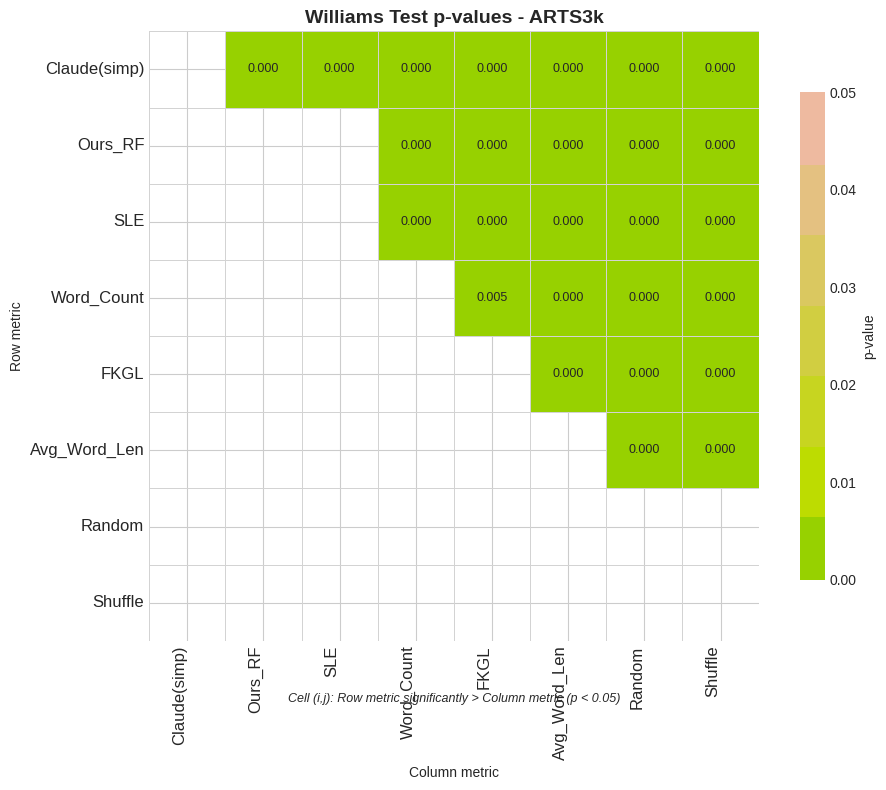

In [8]:
# Plot individual heatmap for a specific dataset (e.g., ARTS3k)
dataset_name = 'ARTS3k'
result = significance_results[dataset_name]

fig = plot_williams_heatmap(
    result['p_value_matrix'],
    alpha=ALPHA,
    title=f'Williams Test p-values - {dataset_name}',
    figsize=(10, 8),
    show_only_significant=True,
)
plt.savefig(figures_dir / f'williams_{dataset_name}.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Top Metrics by Dataset

In [9]:
print('Top Metrics (not significantly outperformed):')
print('=' * 60)

for dataset_name, result in significance_results.items():
    top = result['top_metrics']
    best = result['correlations_df'].iloc[0]
    print(f'\n{dataset_name} (n={result["n_samples"]}):')
    print(f'  Best: {best["metric"]} (r={best["correlation"]:.3f})')
    print(f'  Top group: {top}')

Top Metrics (not significantly outperformed):

ARTS94 (n=94):
  Best: Ours_RF (r=0.792)
  Top group: ['Ours_RF', 'BATS-GB']

ARTS300 (n=300):
  Best: Claude(simp) (r=-0.727)
  Top group: ['Claude(simp)']

ARTS3k (n=2999):
  Best: Claude(simp) (r=-0.688)
  Top group: ['Claude(simp)']

SDA (n=600):
  Best: Claude(simp+src+ref) (r=0.725)
  Top group: ['Claude(simp+src+ref)']

ST-sent (n=1620):
  Best: BATS-RF (r=0.676)
  Top group: ['BATS-RF', 'Ours_RF', 'BATS-GB']

ST-para (n=271):
  Best: SARI (r=0.317)
  Top group: ['SARI', 'Claude(simp)', 'BLEU']

D-Wiki (n=601):
  Best: BATS-RF (r=0.608)
  Top group: ['BATS-RF', 'Claude(simp+src)']


## 7. Cross-Dataset Consistency

In [10]:
# Which metrics are consistently top?
all_top = {}
for dataset_name, result in significance_results.items():
    for m in result['top_metrics']:
        if m not in all_top:
            all_top[m] = []
        all_top[m].append(dataset_name)

consistency = [{'Metric': m, 'Datasets': len(d), 'In': ', '.join(d)} for m, d in all_top.items()]
consistency_df = pd.DataFrame(consistency).sort_values('Datasets', ascending=False)

print('Metrics in top group across datasets:')
display(consistency_df)

Metrics in top group across datasets:


,Metric,Datasets,In
2,Claude(simp),3,"ARTS300, ARTS3k, ST-para"
0,Ours_RF,2,"ARTS94, ST-sent"
1,BATS-GB,2,"ARTS94, ST-sent"
4,BATS-RF,2,"ST-sent, D-Wiki"
3,Claude(simp+src+ref),1,SDA
5,SARI,1,ST-para
6,BLEU,1,ST-para
7,Claude(simp+src),1,D-Wiki


## 8. Summary

In [11]:
print('SUMMARY')
print('=' * 60)
print(f'Alpha level: {ALPHA}')
print(f'Datasets analyzed: {len(significance_results)}')

print('\nMost consistent top metrics:')
for _, row in consistency_df.head(5).iterrows():
    print(f'  {row["Metric"]}: top in {row["Datasets"]} datasets')

SUMMARY
Alpha level: 0.05
Datasets analyzed: 7

Most consistent top metrics:
  Claude(simp): top in 3 datasets
  Ours_RF: top in 2 datasets
  BATS-GB: top in 2 datasets
  BATS-RF: top in 2 datasets
  Claude(simp+src+ref): top in 1 datasets
